## Mini-Project 2: Network Intrusion Detector


#### CSC 180  Intelligent Systems (Fall 2019)
#### Derrek Gass, Alexander Lee, Jimmy Le
#### 10-11-2019

In [2]:
#%qtconsole
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show

import collections

from dask.distributed import Client, progress
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='2GB')

import io
import requests
import shutil
import os, json
import csv

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.feature_extraction.text as sk_text
from sklearn.metrics import confusion_matrix, classification_report


import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, regularizers




# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

    
# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
client

/Users/derrekgass/anaconda3/lib/python3.7/site-packages/distributed/bokeh/core.py:55: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: inproc://192.168.1.65/22610/7 Dashboard: http://localhost:53637/status,Cluster Workers: 1 Cores: 4 Memory: 2.00 GB


In [3]:
import dask.array as da
x = da.random.random((10000, 10000), chunks=(1000, 1000))
x

dask.array<random_sample, shape=(10000, 10000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [4]:
y = x + x.T
z = y[::2, 5000:].mean(axis=1)
z

dask.array<mean_agg-aggregate, shape=(5000,), dtype=float64, chunksize=(500,), chunktype=numpy.ndarray>

In [5]:
#load csv into pandas dataframe
df = pd.read_csv('data/network_intrusion_data.csv', delimiter =",", encoding="utf-8")

In [6]:
z.compute()

array([1.00303097, 0.98778147, 1.00020393, ..., 0.99997118, 0.996316  ,
       1.00921799])

In [51]:
#sort by business_id (arbitrary)
df = df.sort_values(by='business_id',ascending=False)

In [52]:
df.shape

(192609, 5)

In [7]:
#remove_outliers(df, "overall_rating", 2.8)

In [12]:
df.shape

(10000, 5)

In [53]:
preprocess = False
if preprocess:
    encode_numeric_zscore(df, 'overall_rating')

df = df.head(50000)


In [54]:
df.head()

,business_id,name,review_count,overall_rating,all_reviews
102363,zzzaIBwimxVej4tY6qFOUQ,Guthrie's,37,3.5,"b""Way overpriced $35.99 Family Meal, tasteless..."
128923,zzwicjPC9g246MK2M1ZFBA,Sizzler,70,3.0,b'Food not good no selection..bad service +Qat...
84505,zzwhN7x37nyjP0ZM8oiHmw,Carmody's Grille,54,4.0,b'This place is a hidden gem! The pickle fries...
117699,zzwaS0xn1MVEPEf0hNLjew,Dilly Dally Lounge,68,3.5,"b'Though, I never had a friend with a grandma ..."
117454,zzvlwkcNR1CCqOPXwuvz2A,7 Dim Sum,7,3.5,"b""I came here on a Friday night looking for a ..."


In [108]:
vectorizer = sk_text.TfidfVectorizer(stop_words='english',
                                    max_features=2000,
                                    min_df=1)

corpus = df['all_reviews']
matrix = vectorizer.fit_transform(corpus)
tfidf_data = matrix.toarray()

In [109]:
print(type(matrix))
print(tfidf_data.shape)
print(tfidf_data.dtype)
print(type(tfidf_data))
print(tfidf_data)

<class 'scipy.sparse.csr.csr_matrix'>
(50000, 2000)
float64
<class 'numpy.ndarray'>
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.00894238 0.02473862 0.         ... 0.00579212 0.00997636 0.0051791 ]
 [0.         0.0183471  0.         ... 0.         0.         0.        ]
 ...
 [0.         0.01492723 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.01709056 0.         ... 0.         0.         0.        ]]


In [110]:
#print(vectorizer.get_feature_names())
y = df['overall_rating']

In [111]:
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(tfidf_data, y, test_size=0.25, random_state=42)

In [112]:
x_train.shape

(37500, 2000)

In [113]:
y_train.shape

(37500,)

In [114]:
x_test.shape

(12500, 2000)

In [115]:
y_test.shape

(12500,)

Train on 37500 samples, validate on 12500 samples
Epoch 1/100
37500/37500 - 5s - loss: 1.5847 - val_loss: 0.7340
Epoch 2/100
37500/37500 - 2s - loss: 0.4707 - val_loss: 0.3450
Epoch 3/100
37500/37500 - 2s - loss: 0.3484 - val_loss: 0.3012
Epoch 4/100
37500/37500 - 2s - loss: 0.3128 - val_loss: 0.2828
Epoch 5/100
37500/37500 - 2s - loss: 0.2929 - val_loss: 0.2755
Epoch 6/100
37500/37500 - 2s - loss: 0.2841 - val_loss: 0.2615
Epoch 7/100
37500/37500 - 2s - loss: 0.2760 - val_loss: 0.2638
Epoch 8/100
37500/37500 - 2s - loss: 0.2643 - val_loss: 0.2561
Epoch 9/100
37500/37500 - 2s - loss: 0.2616 - val_loss: 0.2487
Epoch 10/100
37500/37500 - 2s - loss: 0.2572 - val_loss: 0.2443
Epoch 11/100
37500/37500 - 2s - loss: 0.2552 - val_loss: 0.2479
Epoch 12/100
37500/37500 - 2s - loss: 0.2537 - val_loss: 0.2419
Epoch 13/100
37500/37500 - 2s - loss: 0.2483 - val_loss: 0.2372
Epoch 14/100
37500/37500 - 2s - loss: 0.2450 - val_loss: 0.2367
Epoch 15/100
37500/37500 - 2s - loss: 0.2419 - val_loss: 0.2342

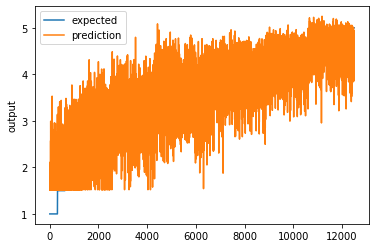

In [127]:
model = Sequential()
model.add(Dense(32, input_dim=tfidf_data.shape[1], activation='relu')) # Hidden 1
model.add(Dropout(0.1))
model.add(Dense(16, 
                kernel_regularizer=regularizers.l1(0.01),
                activity_regularizer=regularizers.l2(0.01), activation='relu')) # Hidden 2
model.add(Dense(1)) # Output

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False)

#model.compile(loss='mean_squared_error', optimizer=adam)
model.compile(loss='mean_squared_error', optimizer=sgd)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x_train,y_train, validation_data=(x_test, y_test), batch_size=128, callbacks=[monitor, checkpointer], verbose=2,epochs=100)    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
model.load_weights('best_weights.hdf5')

pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE): {}".format(score))
chart_regression(pred.flatten(), y_test.values)

In [128]:
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 0.4522813754826082


In [129]:
# print out prediction
df_y = pd.DataFrame(y_test.values, columns=['expected'])
df_pred = pd.DataFrame(pred, columns=['predicted'])

#rounding
df_pred = np.round(df_pred, decimals=2)

result = pd.concat([df_y, df_pred],axis=1)
result['Δ']=np.absolute(df_pred['predicted']-df_y['expected'])
result.head(15)

,expected,predicted,Δ
0,1.5,1.82,0.32
1,3.5,3.90,0.40
2,2.5,3.29,0.79
3,4.5,4.23,0.27
4,4.5,4.89,0.39
5,2.5,2.53,0.03
6,2.5,3.15,0.65
7,1.5,1.66,0.16
8,3.5,3.08,0.42
9,3.0,2.49,0.51


In [130]:
model.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_120 (Dense)            (None, 32)                64032     
_________________________________________________________________
dropout_36 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_121 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_122 (Dense)            (None, 1)                 17        
Total params: 64,577
Trainable params: 64,577
Non-trainable params: 0
_________________________________________________________________
